In [142]:
# Load libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
plt.rc("font", size=14)
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import seaborn as sns
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)
import warnings
warnings.filterwarnings('ignore')

In [176]:
# load data
transportation = pd.read_csv('Humana_Training_Set.csv', header=0, low_memory="FALSE")

### Data Exploration & Feature Extraction has been done separately in R

In [177]:
# Variables to be initially analyzed
initial_features=['credit_hh_bankcardcredit_60dpd',
           'est_age',
           'rx_generic_pmpm_ct',
           'cms_tot_partd_payment_amt',
           'rx_maint_pmpm_ct',
           'smoker_former_ind',
           'hlth_pgm_slvrsnkr_par_status',
           'betos_o1a_ind',
           'credit_bal_nonmtgcredit_60dpd',
           'cms_risk_adj_payment_rate_a_amt',
           'cms_low_income_ind',
           'cons_hcaccprf_h',
           'total_er_visit_ct_pmpm',
           'credit_num_agencyfirstmtg_60dpd',
           'cms_rx_risk_score_nbr',
           'betos_o1a_pmpm_ct',
           'cons_hcaccprf_p',
           'rx_overall_pmpm_ct',
           'credit_hh_studentloan',
           'smoker_current_ind',
           'cms_disabled_ind',
           'cons_hhcomp',
           'med_ambulance_visit_ct_pmpm',
           'credit_num_1stmtg_bankruptcy',
            'rx_ind_sum',
            'rx_pmpm_count',
            'rev_codes$total',
            'visits_count',
            'ccsp_sum',
            'betos_t1a_pmpm_ct',
           'transportation_issues']

### Data Preparartion

In [178]:
# Displaying the categories under Household Composition
transportation['cons_hhcomp'].unique()

array([nan, 'U', 'C', 'J', 'L', 'B', 'H', 'A', 'K', 'D', 'G', 'E', 'F',
       'I'], dtype=object)

In [179]:
# Converting the Household Composition data into households with single and multiple individuals
# 2: Multiple Individuals 1: Single Individual 0: Unknown
transportation['cons_hhcomp']=np.where((transportation['cons_hhcomp'] =='A') | (transportation['cons_hhcomp'] =='C') | (transportation['cons_hhcomp'] =='E') | (transportation['cons_hhcomp'] =='G') | (transportation['cons_hhcomp'] =='I') | (transportation['cons_hhcomp'] =='K'), 2, transportation['cons_hhcomp'])
transportation['cons_hhcomp']=np.where((transportation['cons_hhcomp'] =='B') | (transportation['cons_hhcomp'] =='D') | (transportation['cons_hhcomp'] =='F') | (transportation['cons_hhcomp'] =='H') | (transportation['cons_hhcomp'] =='J') | (transportation['cons_hhcomp']=='L') | (transportation['cons_hhcomp']==None) | (transportation['cons_hhcomp']=='U'), 1, transportation['cons_hhcomp'])

In [180]:
# Displaying the categories under Medicare Segmentation
transportation['mabh_seg'].unique()

array(['UNK', 'C2', 'H6', 'H2', 'H3', 'H4', 'H1', 'C4', 'C5', 'H7', 'H5',
       'C1', 'C7', 'C3', 'H8', 'C6'], dtype=object)

In [181]:
# Converting the Medicare Segmentation data into Healthy and Chronic
# 2: Healthy 1: Chronic 0: Unknown
transportation['mabh_seg']=np.where((transportation['mabh_seg'] == 'H1') | (transportation['mabh_seg'] == 'H2') | (transportation['mabh_seg'] == 'H3') | (transportation['mabh_seg'] == 'H4') | (transportation['mabh_seg'] == 'H5') | (transportation['mabh_seg'] == 'H6') | (transportation['mabh_seg'] == 'H7') | (transportation['mabh_seg'] == 'H8'), 'Healthy', transportation['mabh_seg'])
transportation['mabh_seg']=np.where((transportation['mabh_seg'] == 'C1') | (transportation['mabh_seg'] == 'C2') | (transportation['mabh_seg'] == 'C3') | (transportation['mabh_seg'] == 'C4') | (transportation['mabh_seg'] == 'C5') | (transportation['mabh_seg'] == 'C6') | (transportation['mabh_seg'] == 'C7'), 'Chronic', transportation['mabh_seg'])
transportation['mabh_seg']=np.where(transportation['mabh_seg'] == 'UNK', "Unknown", transportation['mabh_seg'])

In [182]:
# Displaying the categories under different Categorical Variables
transportation['sex_cd'].unique()

array(['F', 'M'], dtype=object)

In [183]:
# Creating dummy variables for categorical varaibles 
cat_vars=['sex_cd', 'mabh_seg']
for var in cat_vars:
    cat_list='var'+'_'+var
    cat_list = pd.get_dummies(transportation[var], prefix=var)
    datanew=transportation.join(cat_list)
    transportation=datanew
    initial_features = initial_features + cat_list.columns.values.tolist()

In [184]:
# Converting the Non-numeric Zip Code to Numeric 
transportation['zip_cd']=np.where((transportation['zip_cd'] == 'other') , 0, (transportation['zip_cd']))

In [185]:
# Converting the Non-numeric County Code to Numeric
transportation['cnty_cd']=np.where((transportation['cnty_cd'] == 'other') , 0, (transportation['cnty_cd']))

In [186]:
# Relacing the missing values with 0 
for var in initial_features:
    transportation[var].fillna(0, inplace=True)

In [187]:
# Creating a subset of the variables defined
transportation_final=transportation[initial_features]

In [188]:
# List of final columns including dummy variables
transportation_final.columns.values

array(['credit_hh_bankcardcredit_60dpd', 'est_age', 'rx_generic_pmpm_ct',
       'cms_tot_partd_payment_amt', 'rx_maint_pmpm_ct',
       'smoker_former_ind', 'hlth_pgm_slvrsnkr_par_status',
       'betos_o1a_ind', 'credit_bal_nonmtgcredit_60dpd',
       'cms_risk_adj_payment_rate_a_amt', 'cms_low_income_ind',
       'cons_hcaccprf_h', 'total_er_visit_ct_pmpm',
       'credit_num_agencyfirstmtg_60dpd', 'cms_rx_risk_score_nbr',
       'betos_o1a_pmpm_ct', 'cons_hcaccprf_p', 'rx_overall_pmpm_ct',
       'credit_hh_studentloan', 'smoker_current_ind', 'cms_disabled_ind',
       'cons_hhcomp', 'med_ambulance_visit_ct_pmpm',
       'credit_num_1stmtg_bankruptcy', 'rx_ind_sum', 'rx_pmpm_count',
       'rev_codes$total', 'visits_count', 'ccsp_sum', 'betos_t1a_pmpm_ct',
       'transportation_issues', 'sex_cd_F', 'sex_cd_M',
       'mabh_seg_Chronic', 'mabh_seg_Healthy', 'mabh_seg_Unknown'],
      dtype=object)

### Dealing with Oversampling

In [189]:
# Displaying the counts of each category in the response variable
transportation_final['transportation_issues'].value_counts()

0    59375
1    10197
Name: transportation_issues, dtype: int64

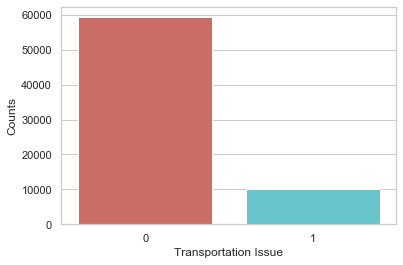

In [190]:
# Visualizing the Imbalance in our Response Variable
sns.countplot(x='transportation_issues', data=transportation_final, palette='hls')
plt.show
plt.xlabel('Transportation Issue')
plt.ylabel('Counts')
plt.savefig('transportation_issues_plot')

In [191]:
# Dealing with Overfitting of data 

X = transportation_final.loc[:, transportation_final.columns != 'transportation_issues']
y = transportation_final.loc[:, transportation_final.columns == 'transportation_issues']

from imblearn import over_sampling
from imblearn.over_sampling import SMOTE

os = SMOTE(random_state=0)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)
columns = X_train.columns
os_data_X,os_data_y=os.fit_sample(X, y)
os_data_X = pd.DataFrame(data=os_data_X,columns=columns )
os_data_y= pd.DataFrame(data=os_data_y,columns=['transportation_issues'])

# Displaying the number of each records in oversampled data
print("Length of oversampled data: ",len(os_data_X))
print("Number of records without transportation issues: ",len(os_data_y[os_data_y['transportation_issues']==0]))
print("Number of records with transportation issues: ",len(os_data_y[os_data_y['transportation_issues']==1]))
#print("Proportion of no issues data in oversampled data is ",len(os_data_y[os_data_y['transportation_issues']==0])/len(os_data_X))
#print("Proportion of issues data in oversampled data is ",len(os_data_y[os_data_y['transportation_issues']==1])/len(os_data_X))

Length of oversampled data:  118750
Number of records without transportation issues:  59375
Number of records with transportation issues:  59375


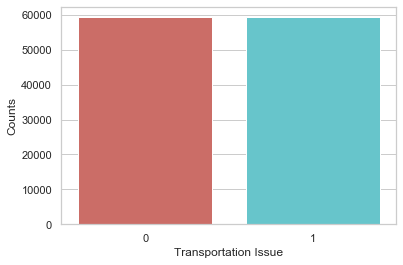

In [192]:
# Visualizing the Oversampled Data for our Response Variable
sns.countplot(x='transportation_issues', data=os_data_y, palette='hls')
plt.show
plt.xlabel('Transportation Issue')
plt.ylabel('Counts')
plt.savefig('transportation_issues_plot_balanced')

In [193]:
# Remove the y (response variable) from the list of final selected variables
initial_features.remove('transportation_issues')

In [196]:
# Creating the final X, y dataset for the logistic model
X_train = os_data_X[initial_features]
y_train = os_data_y['transportation_issues']

In [195]:
X = transportation_final.loc[:, transportation_final.columns != 'transportation_issues']
y = transportation_final.loc[:, transportation_final.columns == 'transportation_issues']

### Implementing the model 

In [197]:
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y)
# Running the logistic model for selecting the final input variables
import statsmodels.api as sm
logit_model=sm.Logit(y_train,X_train.astype(float))
result=logit_model.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.411860
         Iterations 8
                                  Results: Logit
Model:                  Logit                     Pseudo R-squared:     0.406     
Dependent Variable:     transportation_issues     AIC:                  97886.6870
Date:                   2020-10-11 20:08          BIC:                  98225.6541
No. Observations:       118750                    Log-Likelihood:       -48908.   
Df Model:               34                        LL-Null:              -82311.   
Df Residuals:           118715                    LLR p-value:          0.0000    
Converged:              1.0000                    Scale:                1.0000    
No. Iterations:         8.0000                                                    
----------------------------------------------------------------------------------
                                 Coef.   Std.Err.    z     P>|z|   [0.025   0.975]
-------------------

In [198]:
final_features=['credit_hh_bankcardcredit_60dpd',
           'est_age',
           'rx_generic_pmpm_ct',
           'cms_tot_partd_payment_amt',
           'smoker_former_ind',
           'hlth_pgm_slvrsnkr_par_status',
           'cons_hcaccprf_h',
           'total_er_visit_ct_pmpm',
           'cms_rx_risk_score_nbr',
           'betos_o1a_pmpm_ct',
           'cons_hcaccprf_p',
           'rx_overall_pmpm_ct',
           'credit_hh_studentloan',
           'smoker_current_ind',
           'cms_disabled_ind',
           'cons_hhcomp',
           'med_ambulance_visit_ct_pmpm',
           'credit_num_1stmtg_bankruptcy',
            'visits_count',
            'ccsp_sum',
            'betos_t1a_pmpm_ct',
           'mabh_seg_Chronic', 
           'mabh_seg_Healthy', 
           'mabh_seg_Unknown',
           'sex_cd_F', 
           'sex_cd_M']

In [199]:
# Reloading the data with the new set of variables
X_train = os_data_X[final_features]
y_train = os_data_y['transportation_issues']

In [129]:
X = transportation_final[final_features]
y = transportation_final['transportation_issues']

In [200]:
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y)
# Running the 2nd interation of logistic model for selecting the final input variables
logit_model=sm.Logit(y_train,X_train.astype(float))
result=logit_model.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.412243
         Iterations 7
                                 Results: Logit
Model:                   Logit                    Pseudo R-squared:    0.405     
Dependent Variable:      transportation_issues    AIC:                 97959.7171
Date:                    2020-10-11 20:08         BIC:                 98211.5212
No. Observations:        118750                   Log-Likelihood:      -48954.   
Df Model:                25                       LL-Null:             -82311.   
Df Residuals:            118724                   LLR p-value:         0.0000    
Converged:               1.0000                   Scale:               1.0000    
No. Iterations:          7.0000                                                  
---------------------------------------------------------------------------------
                                Coef.   Std.Err.    z     P>|z|   [0.025   0.975]
------------------------------

In [201]:
# Training the model using Logistic Regression
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
logreg = LogisticRegression(max_iter=5000)
logreg.fit(X_train, y_train)

LogisticRegression(max_iter=5000)

In [202]:
X_test = transportation_final[final_features]
y_test = transportation_final['transportation_issues']

In [59]:
X_test.head()

,credit_hh_bankcardcredit_60dpd,est_age,rx_generic_pmpm_ct,cms_tot_partd_payment_amt,smoker_former_ind,hlth_pgm_slvrsnkr_par_status,cons_hcaccprf_h,total_er_visit_ct_pmpm,cms_rx_risk_score_nbr,betos_o1a_pmpm_ct,...,med_ambulance_visit_ct_pmpm,credit_num_1stmtg_bankruptcy,visits_count,ccsp_sum,betos_t1a_pmpm_ct,mabh_seg_Chronic,mabh_seg_Healthy,mabh_seg_Unknown,sex_cd_F,sex_cd_M
0,16.471706,62,0.100552,0.00,0,0,0.0,0.000000,0.000,0.00,...,0.000000,0.000632,0.173423,0,0.000000,0,0,1,1,0
1,10.820296,59,2.245541,293.47,0,1,0.0,0.000000,1.728,0.00,...,0.000000,0.000000,0.177731,1,0.175142,1,0,0,1,0
2,9.517801,63,2.500000,318.68,0,0,0.0,0.000000,1.894,1.25,...,2.316067,0.000927,2.732733,3,0.000000,0,0,1,1,0
3,12.925935,75,2.666667,250.63,0,1,0.0,0.000000,0.769,0.00,...,0.000000,0.000000,0.333333,0,0.000000,0,1,0,0,1
4,13.462593,51,3.666667,383.61,0,0,1.0,0.083333,1.390,0.00,...,0.000000,0.002955,0.750000,0,0.166667,0,0,1,0,1


In [203]:
# Predicting the 'response variable' y (transportation_issues) using the Logistic Regression
y_pred = logreg.predict(X_test)
print('Accuracy (Logistic Regression): {:.2f}'.format(logreg.score(X_test, y_test)))

Accuracy (Logistic Regression): 0.83


In [204]:
# Displaing the Confusion Matrix - Logistic Regression
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, y_pred)
print(confusion_matrix)

[[55770  3605]
 [ 8082  2115]]


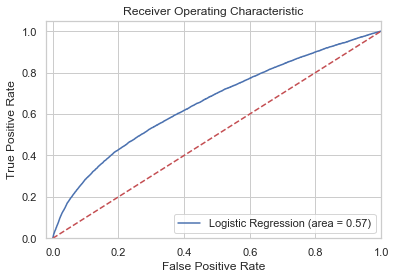

In [205]:
# Displaying the ROC-AUC - Logistic Regression
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
logit_roc_auc = roc_auc_score(y_test, logreg.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([-0.02, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.savefig('Logistic_ROC')
plt.show()

In [206]:
# Training the model using XGBoost
from sklearn import metrics

#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y)
XGBmodel = XGBClassifier()
XGBmodel.fit(X_train.astype(float), y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

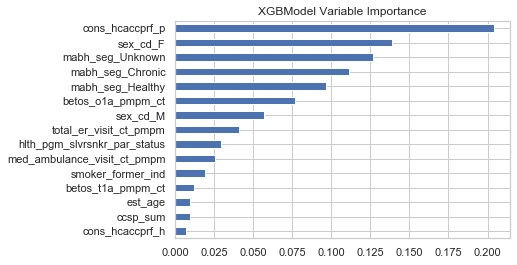

In [207]:
# Displaying the feature importance from XGBoost
importance = pd.Series(XGBmodel.feature_importances_, index=X_train.columns)
XGBmodel_importance = importance.sort_values()[-15:]
XGBmodel_importance.plot.barh()
plt.title('XGBModel Variable Importance')
plt.savefig('XGBModel_V_Importance')

In [208]:
# Predicting the 'response variable' y (transportation_issues) using the XGBoost model
y_pred = XGBmodel.predict(X_test.astype(float))
predictions = [round(value) for value in y_pred]
# evaluate predictions
accuracy = accuracy_score(y_test, predictions)
print('Accuracy (XGBoost): {:.2f}' .format(accuracy))

Accuracy (XGBoost): 0.88


In [209]:
# Displaing the Confusion Matrix - XGBoost
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, y_pred)
print(confusion_matrix)

[[58493   882]
 [ 7391  2806]]


In [210]:
# Displaying the XGBoost model statistics
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.89      0.99      0.93     59375
           1       0.76      0.28      0.40     10197

    accuracy                           0.88     69572
   macro avg       0.82      0.63      0.67     69572
weighted avg       0.87      0.88      0.86     69572



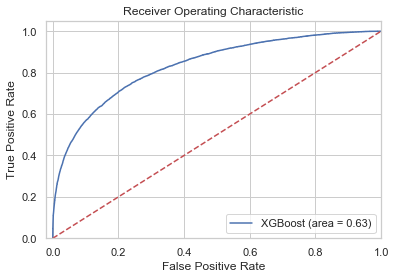

In [211]:
# Displaying the ROC-AUC - XGBoost 
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
xgb_roc_auc = roc_auc_score(y_test, XGBmodel.predict(X_test.astype(float)))
fpr, tpr, thresholds = roc_curve(y_test, XGBmodel.predict_proba(X_test.astype(float))[:,1])
plt.figure()
plt.plot(fpr, tpr, label='XGBoost (area = %0.2f)' % xgb_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([-0.02, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.savefig('XGBoost_ROC')
plt.show()

In [212]:
# Performing the kfold validation for robustness
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
kfold = KFold(n_splits=10, random_state=7)
results = cross_val_score(XGBmodel, X, y, cv=kfold)
print("Accuracy: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

Accuracy: 85.21% (0.30%)


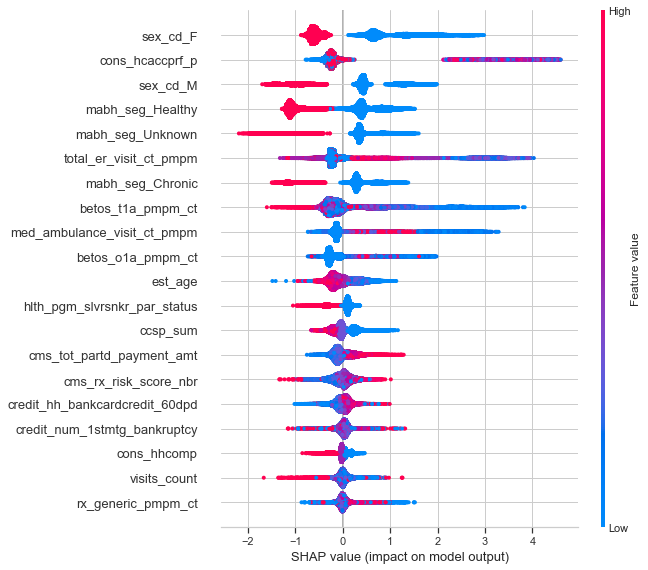

In [76]:
# Validating the impact of the features on the response variable
import shap
shap.initjs()
explainer = shap.TreeExplainer(XGBmodel)
shap_values = explainer.shap_values(X_train)
shap.summary_plot(shap_values, features=X_train, feature_names=X_train.columns)

In [77]:
# Feature engineering on the holdout set 
holdout = pd.read_csv('Humana_Holdout_Set.csv', header=0, low_memory="FALSE")

# Converting the Medicare Segmentation data into Healthy and Chronic
# 2: Healthy 1: Chronic 0: Unknown
holdout['mabh_seg']=np.where((holdout['mabh_seg'] == 'H1') | (holdout['mabh_seg'] == 'H2') | (holdout['mabh_seg'] == 'H3') | (holdout['mabh_seg'] == 'H4') | (holdout['mabh_seg'] == 'H5') | (holdout['mabh_seg'] == 'H6') | (holdout['mabh_seg'] == 'H7') | (holdout['mabh_seg'] == 'H8'), 'Healthy', holdout['mabh_seg'])
holdout['mabh_seg']=np.where((holdout['mabh_seg'] == 'C1') | (holdout['mabh_seg'] == 'C2') | (holdout['mabh_seg'] == 'C3') | (holdout['mabh_seg'] == 'C4') | (holdout['mabh_seg'] == 'C5') | (holdout['mabh_seg'] == 'C6') | (holdout['mabh_seg'] == 'C7'), 'Chronic', holdout['mabh_seg'])
holdout['mabh_seg']=np.where(holdout['mabh_seg'] == 'UNK', "Unknown", holdout['mabh_seg'])

# Converting the Household Composition data into households with single and multiple individuals
# 2: Multiple Individuals 1: Single Individual
holdout['cons_hhcomp']=np.where((holdout['cons_hhcomp'] =='A') | (holdout['cons_hhcomp'] =='C') | (holdout['cons_hhcomp'] =='E') | (holdout['cons_hhcomp'] =='G') | (holdout['cons_hhcomp'] =='I') | (holdout['cons_hhcomp'] =='K'), 2, holdout['cons_hhcomp'])
holdout['cons_hhcomp']=np.where((holdout['cons_hhcomp'] =='B') | (holdout['cons_hhcomp'] =='D') | (holdout['cons_hhcomp'] =='F') | (holdout['cons_hhcomp'] =='H') | (holdout['cons_hhcomp'] =='J') | (holdout['cons_hhcomp'] =='L') | (holdout['cons_hhcomp'] == None) | (holdout['cons_hhcomp']=='U'), 1, holdout['cons_hhcomp'])

# Creating dummy variables for categorical varaibles 
cat_vars=['sex_cd', 'mabh_seg']
for var in cat_vars:
    cat_list='var'+'_'+var
    cat_list = pd.get_dummies(holdout[var], prefix=var)
    datanew=holdout.join(cat_list)
    holdout=datanew

# Relacing the missing values with 0 
for var in final_features:
    transportation[var].fillna(0, inplace=True)
    
holdout_test = holdout[final_features]
holdout_personid = holdout['person_id_syn']

In [78]:
# Predicting the values for the Holdout dataset
Holdout_Submission = pd.DataFrame()
Holdout_Submission['ID'] = holdout_personid
Holdout_Submission['PredProb'] = XGBmodel.predict_proba(holdout_test.astype(float))[:,1]
Holdout_Submission = Holdout_Submission.sort_values(by = ['PredProb'],ascending = False)
Holdout_index = Holdout_Submission.index
Rank = list(range(0,len(Holdout_index)))
Holdout_Submission["Rank"] = np.asarray(Rank) + 1

#Holdout_Submission = Holdout_Submission.reset_index()
#Creating the final output file 
Holdout_Submission.columns = ['ID', 'Predicted Value', 'Individual Rank']
Holdout_Submission.to_csv('Holdout Submission File.csv', index=False) 
Holdout_Submission

,ID,Predicted Value,Individual Rank
9514,M86Ob84bST8Le0016YAfIfaf,0.986444,1
9102,M6OSTLYf2d1dc844ab618AIc,0.974286,2
11752,Ma164OfST037c3fLYd38AIf9,0.962169,3
1154,1M8O3ScTL3796dc7e49YA06I,0.959005,4
5402,76M5O4Sf749TL989dY6dA72I,0.958798,5
...,...,...,...
6105,848MOS433aT4b39LYbA6I819,0.005617,17677
6375,8MO1S90fTb83a8LdaYe16eAI,0.005277,17678
15112,c9MOf04e49STLe3f60YdA2I7,0.004559,17679
8826,M5O0Scfeeab18f9T1LY0A0Ia,0.004166,17680
